# Дисбаланс выборки

**Несбалансированная выборка (imbalanced dataset)** — выборка, в которой количество примеров каких-то классов сильно превалирует над количеством примеров других классов. Это определение также можно расширить на другие типы задач. Например, в задаче регрессии дисбалансом выборки будет ситуация, при которой распределение целевых значений будет сильно отличаться от равномерного.

## Когда считать выборку несбалансированной?

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
titanic = pd.read_csv('./data/titanic.csv')
titanic.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


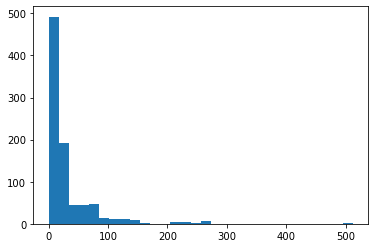

In [3]:
plt.hist(titanic['Fare'], bins=30);

<AxesSubplot:xlabel='Survived', ylabel='count'>

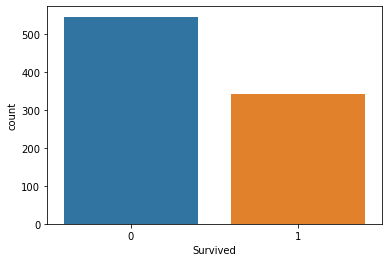

In [4]:
sns.countplot(x='Survived', data=titanic)

Нет точного определения, когда считать выборку несбалансированной. Неформально считается, что выборка несбалансированна, когда отношение количества преобладающего и минорного классов составляет 10:1.

## Последствия дисбаланса данных

Что происходит при дисбалансе классов:
1. У алгоритма появляется склонность к более популярным классам/значениям.
1. Невозможность использования метрик, не учитывающих веса классов (базовая метрика accuracy, изученная выше, не может быть использована).

## Решение проблемы

1. Изменить целевую метрику — в задачах классификации confusion matrix, precision, recall, F1-score, ROC-кривые будут намного корректнее описывать алгоритм, чем accuracy.
1. Изменить выборку данных: 1) oversampling — увеличение кол-ва объектов классов-меньшинств; 2) undersampling — сокращение кол-ва объектов превалирующих классов.
1. Добавить штраф в оптимизационный функционал, прямо пропорциональный кол-ву объектов каждого класса (веса классов).
1. Возможно, есть смысл перейти к задачам [Anomaly detection](https://en.wikipedia.org/wiki/Anomaly_detection) и [Change detection](https://en.wikipedia.org/wiki/Change_detection).

Во 2-м способе решение проблемы oversampling может быть выполнено как простым дублированием примеров меньшего класса, так и и более сложной техникой, называемой "аугментацией выборки".

**Аугментация выборки (data augmentation)** — процесс генерации примеров из исходных путем их модификации. Примерами аугментации данных могут служить: повороты, масштабирование изображений, применение фильтров; для текста может быть незначительно изменен контекст и изменено склонение/спряжение слов.

Еще одна техника, которая может быть использована для oversampling это **обогащение данных**. При использовании этой техники данные находятся во внешних дополнительных источниках. Например, если банк решает свою скоринговую задачу, он может также расширить свой набор данных данными другого банка при их наличии.

### Задание

Загрузите данные dataset, оставьте в данных только признаки `'fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due', 'compliance'`, затем избавьтесь от пропусков.

Обучим модель на несбалансированных данных. Целевой переменной будет `'compliance'`, разделите данные на обучающую и тестовую выборки в соотношении 70%/30% без перемешивания.

Обучите `DecisionTreeClassifier` из scikit-learn с параметром `random_state=23`. Посчитайте значения метрики  на тренировочной выборке и на тестовой выборке.

Затем сделайте эту же выборку сбалансированной с помощью undersampling.

Для этого посчитайте количество примеров `(n)` класса-меньшинства, затем из класса-большинства возьмите n первых примеров.

То есть, в терминологии Python, возьмите срез (slice) от начала и до `n`, где `n` — количество примеров класса, которого в выборке представлено меньше.

Соедините две части выборки (с уменьшенным классом-большинством и с изначальным классом-меньшинством), сделайте точно такое же разбиение, как в задаче выше, и обучите такую же модель.

Посчитайте значение метрики  на новой тестовой выборке с помощью новой модели. Вычтите из значения метрики на тестовой части сбалансированной выборки значение метрики на тестовой части несбалансированной выборки и выведите результат.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score

In [6]:
vis_data = pd.read_csv(
        "./data/train.csv", encoding='ISO-8859-1', low_memory=False)

In [7]:
def get_min_max_df(data):
    df_0 = data[data['compliance'] == 0]
    df_1 = data[data['compliance'] == 1]
    
    if len(df_0) > len(df_1):
        return df_1, df_0
    else:
        return df_0, df_1

In [8]:
def data_preprocessing(data, undersampling=False):
    vis_data = data.copy()
    
    vis_data = vis_data[['fine_amount', 'state_fee', 'late_fee',
                         'discount_amount', 'balance_due', 'compliance']]

    vis_data = vis_data.dropna()

    if undersampling:
        min_df, max_df = get_min_max_df(vis_data)
        max_df_cat = max_df.iloc[:len(min_df)]
        vis_data = pd.concat([max_df_cat, min_df], axis=0)

    sns.countplot(x='compliance', data=vis_data)

    X = vis_data.drop(columns=['compliance'])
    y = vis_data['compliance']

    return train_test_split(X, y, test_size=0.3, shuffle=False)

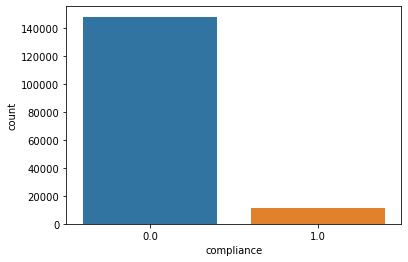

In [9]:
X_train, X_test, y_train, y_test = data_preprocessing(vis_data)

In [10]:
clf = DecisionTreeClassifier(random_state=23)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
f1_val_train = f1_score(y_train, y_pred)

print('[train] F1-score = {:.2f}'.format(f1_val_train))

y_pred = clf.predict(X_test)
f1_val_test = f1_score(y_test, y_pred)

print('[test] F1-score = {:.2f}'.format(f1_val_test))

[train] F1-score = 0.66
[test] F1-score = 0.58


Проведем операцию undersampling:

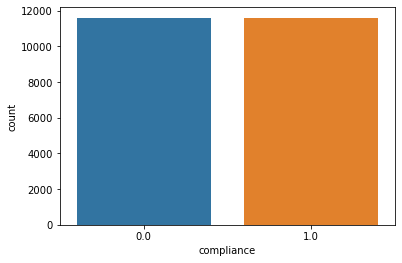

In [11]:
X_train, X_test, y_train, y_test = data_preprocessing(vis_data, True)

In [12]:
clf = DecisionTreeClassifier(random_state=23)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
f1_val_train = f1_score(y_train, y_pred)

print('[train] F1-score = {:.2f}'.format(f1_val_train))

y_pred = clf.predict(X_test)
f1_val_test = f1_score(y_test, y_pred)

print('[test] F1-score = {:.2f}'.format(f1_val_test))

[train] F1-score = 0.92
[test] F1-score = 0.76
